In [1]:
%reset -f
import tensorflow as tf
from importlib import reload
sess = tf.InteractiveSession()
import os
import random
from params import * 
import world 
from copy import copy
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from network import * 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
my_world = world.world()
num_actions= 4
dqn_args   = {"n_out_h1" : 16, "kernel_size_h1":(8,8), "strides_h1" : 4, "padding" : "SAME", \
              "actvt_fct" : tf.nn.relu, "n_out_h2" : 32, "kernel_size_h2":(4,4), "strides_h2" : 2, \
              "n_out_h3" : 128,"initializer" : tf.contrib.layers.variance_scaling_initializer() }


In [4]:
learner_out  , learner_vars   = network("learner"  ,**dqn_args,num_actions = num_actions)
predictor_out, predictor_vars = network("predictor",**dqn_args,num_actions = num_actions)

In [5]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [19]:
save_path = "learnt_var-weird_reward_structure/"


In [25]:
game_length = 0
play_game_length_over_t = []
play_time = []
range_x  = int(FRAME_DIM/2-MARGIN)
range_y  = int(FRAME_DIM/2-MARGIN)
parameter_space = np.array([(haxis,vaxis) for haxis in np.arange(1,range_x+1)\
                                          for vaxis in np.arange(1,range_y+1)])
max_qs = np.zeros((range_x+1,range_y+1))
all_qs = np.zeros((range_x+1,range_y+1,4))

with tf.Session() as sess:
    
    if os.path.isfile(save_path+".index"):
        saver.restore(sess, save_path)
        
        
        for ellipse in parameter_space:
            my_world.haxis = ellipse[0]
            my_world.vaxis = ellipse[1]
            
            my_world.set_frame()
            
            state = my_world.get_frame()
            
            q_values = predictor_out.eval(feed_dict={x: [state]})
            max_q = np.mean(q_values)
            all_qs[ellipse[0]][ellipse[1]] = q_values
            max_qs[ellipse[0]][ellipse[1]] = max_q


INFO:tensorflow:Restoring parameters from learnt_var-weird_reward_structure/


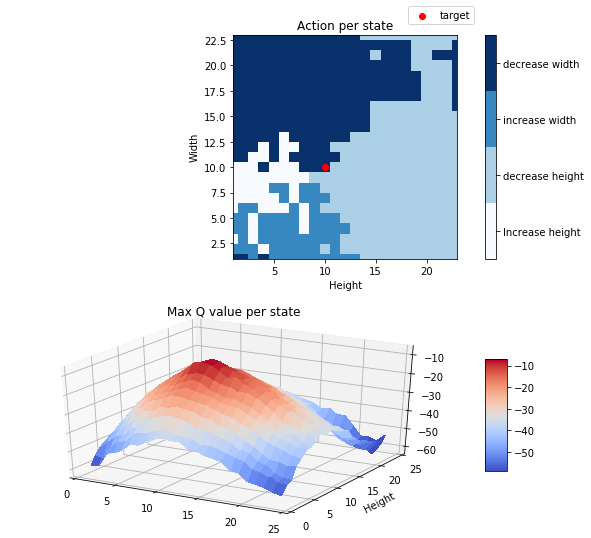

In [107]:
from matplotlib import colors as clrs


fig = plt.figure(figsize=(10,14))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312,projection="3d")
cmap=plt.cm.Blues

norm = clrs.BoundaryNorm(np.arange(-.5,4.5), cmap.N)

im = ax1.imshow(np.argmax(all_qs[1:,1:],axis=2),norm=norm,cmap=cmap)
ax1.set_title("Action per state")
ax1.set_xlim(1,range_x-1)
ax1.set_ylim(1,range_y-1)
ax1.set_xlabel("Height")
ax1.set_ylabel("Width")
cbar = fig.colorbar(im,ticks=np.arange(4),spacing="uniform",ax=ax1)

ax1.scatter(10,10,color="red",label="target")
ax1.legend(bbox_to_anchor=[1.1,1.15])
cbar.ax.set_yticklabels(['Increase height', 'decrease height', 'increase width','decrease width']);



X = np.arange(1, range_x+1)
Y = np.arange(1, range_y+1)
X, Y = np.meshgrid(X, Y)


surf = ax2.plot_surface(X, Y, max_qs[1:,1:], rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax2.set_ylabel("Width")
ax2.set_ylabel("Height")
ax2.set_title("Max Q value per state")

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

